Zero Shot Object Detection using Segment Anything Model (SAM)

SAM is a new model that can basically segment anything in an image. It accepts prompts: points, bounding boxes, masks and/or text. The output is mask segmentation. 
In this project, the aim is to use SAM to perform zero-shot object detection using COCO 2017 val split. 

Import Libraries

In [1]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import cv2
import numpy as np
import urllib.request
import validators
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from pytriton.client import ModelClient
import multiprocessing
from tqdm.notebook import tqdm_notebook
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Image
import ipywidgets as widgets


Define functions and mlops clients.
Uses the inference server.

In [2]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.5)))
        
def infer_model(url="http://202.92.132.48:8000", image= "https://djl.ai/examples/src/test/resources/dog_bike_car.jpg", model="SAM_h",choice = 2):
    with ModelClient(url, model) as client:
        try:
            if validators.url(image):
                with urllib.request.urlopen(image) as url_response:
                    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                    image = cv2.imdecode(img_array, -1)
            else:
                image = cv2.imread(image)
        except:
            image = image
        if choice != 1:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = cv2.cvtColor(np.array(image), cv2.COLOR_RGBA2RGB)

        outputs = client.infer_sample(image=image)
        segmentation = outputs['segmentation']
        #area = masks['area']
        masks = []
        for i in range(segmentation.shape[0]):
            masks.append({
                'segmentation': segmentation[i,:,:],
                'area': outputs['area'][i],
                "bbox": outputs['bbox'][i],
                # bounding boxes based on segmentation
                #"bboxes" : [min(segmentation[i,:,0]), min(segmentation[i,:,1]), max(segmentation[i,:,0]), max(segmentation[i,:,1])],
                "predicted_iou": outputs['predicted_iou'][i],
                "stability_score": outputs['stability_score'][i],
            })
        
        return image, masks

def infer_modelCLIP(url="http://202.92.132.48:8000", openclip_model = "OpenClip_b32",choice = 2, image= "https://djl.ai/examples/src/test/resources/dog_bike_car.jpg", init_timeout_s = 600):
    with ModelClient(url, openclip_model, init_timeout_s=init_timeout_s) as client:
        try:
            if validators.url(image):
                with urllib.request.urlopen(image) as url_response:
                    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                    image = cv2.imdecode(img_array, -1)
            else:
                image = cv2.imread(image)
        except:
            image = image
        if choice != 1:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = cv2.cvtColor(np.array(image), cv2.COLOR_RGBA2RGB)
        #image = np.expand_dims(image, axis=0)
        #logger.info(f"Running inference requests")
        outputs = client.infer_sample(image)
        
        #for k, v in outputs.items():
        #    if k == "index":
        #        print(k, v, v.shape)
        #    else:
        #        print(v.tobytes().decode('utf-32'))
        return outputs
    
def infer_modelCOCA(url="http://202.92.132.48:8000", coca_model = "CoCa_l14", image = "https://djl.ai/examples/src/test/resources/dog_bike_car.jpg",  init_timeout_s = 600):
                
    with ModelClient(url, coca_model, init_timeout_s=init_timeout_s) as client:
        try:
            if validators.url(image):
                with urllib.request.urlopen(image) as url_response:
                    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                    image = cv2.imdecode(img_array, -1)
            else:
                image = cv2.imread(image)
        except:
            image = image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #logger.info(f"Running inference requests")
        outputs = client.infer_sample(image)
        for k, v in outputs.items():
            print(v.tobytes().decode('utf-32'))
        return outputs

def infer_modelYOLO(url="http://202.92.132.48:8000", image="../sam/images/dog_car.jpg", model="Yolov8x", init_timeout_s = 600,choice = 2):
    with ModelClient(url, model,init_timeout_s = init_timeout_s) as client:
        try:
            if validators.url(image):
                with urllib.request.urlopen(image) as url_response:
                    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                    image = cv2.imdecode(img_array, -1)
            else:
                image = cv2.imread(image)
        except:
            image = image
        if choice != 1:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        else:
            image = cv2.cvtColor(np.array(image), cv2.COLOR_RGBA2RGB)
        outputs = client.infer_sample(image)
        for k, v in outputs.items():
            if k == "names":
                names = v.tobytes().decode('utf-32').split("|")
                names = names[:-1]
            elif k == "bboxes":
                bboxes = v
            elif k == "probs":
                probs = v
        return (names,bboxes,probs)
def detect_object(imgId, coco):
    img = coco.loadImgs(imgId)[0]
    result = []
    try:
        image_path = img['flickr_url']
        image, masks = infer_model(image=image_path)
    except:
        image_path = img['coco_url']
        image, masks = infer_model(image=image_path)

    for mask_idx in range(len(masks)):
        x, y , w, h = masks[mask_idx]['bbox']
        #cropped_image = (image * np.expand_dims(masks[obj_num]['segmentation'],axis=-1) )[y:y+h, x:x+w] #cropped image background is removed
        cropped_image = image[y:y+h, x:x+w] #cropped image background is not removed
        #plt.imshow(cropped_image)
        predictions = infer_modelCLIP( image = np.array(cropped_image))
        predicted_objects = predictions["label"].tobytes().decode('utf-32').split(',')
        in_coco = False
        for each in predicted_objects:
            if each in categories:
                in_coco = True
                result.append({"image_id": imgId,"category_id": coco.getCatIds(catNms=[each])[0], "bbox": masks[mask_idx]['bbox'].tolist(), "score": masks[mask_idx]["stability_score"].tolist()})

    return result

In [3]:
#Insert instances_val2017.json location, if located within the same directory as jupyter notebook file, just press enter"
val2017_location = input("Enter Val 2017 Instances Location:")
if (val2017_location == ""):
    val2017_location = "./instances_val2017.json"
coco=COCO(val2017_location)

cats = coco.loadCats(coco.getCatIds())
categories = [cats[x]["name"] for x in range(len(cats))]
supercategories = [cats[x]["supercategory"] for x in range(len(cats))]
print("Number of categories:", len(categories))

Enter Val 2017 Instances Location:
loading annotations into memory...
Done (t=0.79s)
creating index...
index created!
Number of categories: 80


Demo: Enter an image and ground truth

In [4]:
#Choose method to select image
image_source = ["path ot url", "file upload", "random from coco"] #Corresponds to choice = 0,1,2
choice = int(input("Enter number of image source type, 0:path ot url, 1:file upload, 2:random from coco"))

Enter number of image source type, 0:path ot url, 1:file upload, 2:random from coco2


In [5]:
if choice == 0:
    #Enter an image url or file path
    image_path = input("Enter image path or URL: ")
    print("Loading ",image_path)
elif choice == 1:
    uploader = widgets.FileUpload()
    display(uploader)

elif choice ==2:
    imgIds = coco.getImgIds();
    imgId = imgIds[np.random.randint(0,len(imgIds))]
    img = coco.loadImgs(imgId)[0]
    image_path = img['coco_url']
    print("Random image from coco, coco url: ",image_path)
else:
    print("Choice Invalid, run previous cell again to choose")

Random image from coco, coco url:  http://images.cocodataset.org/val2017/000000488251.jpg


Ground Truth


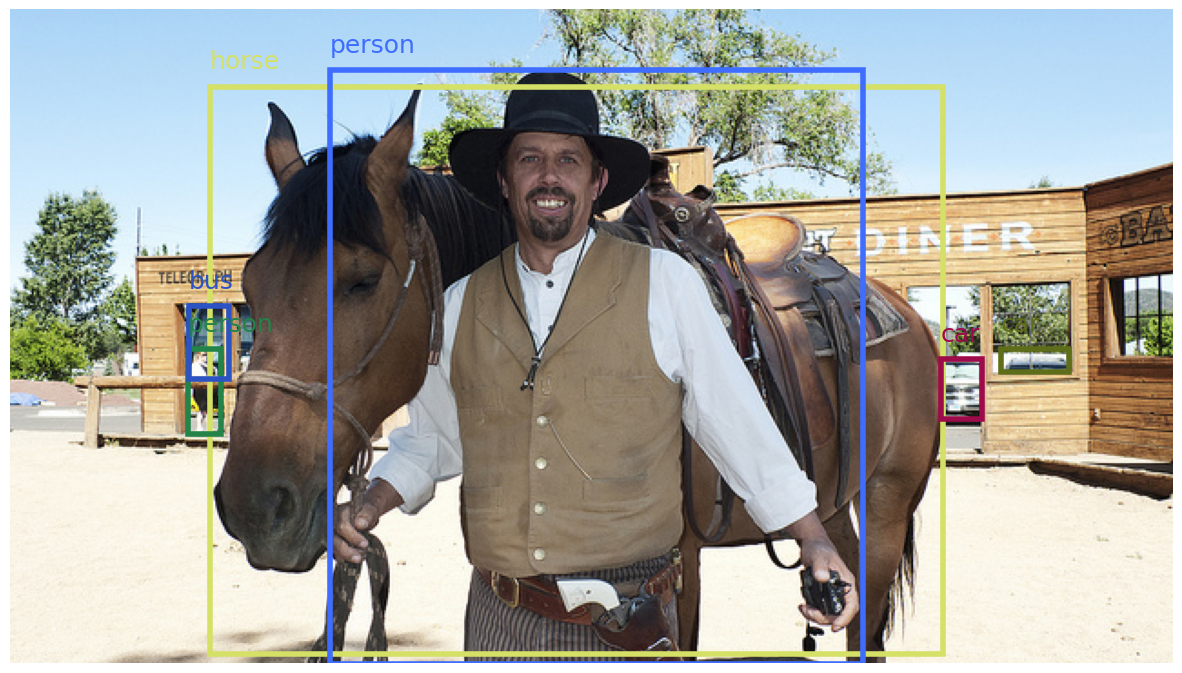

In [6]:
if choice == 2:
    print("Ground Truth")
    image, masks = infer_model(image=image_path)
    
    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(image)
    ax.axis('off')

    annotation_ids = coco.getAnnIds(imgIds=imgId)
    annotations = coco.loadAnns(annotation_ids)

    for annotation in annotations:
            bbox = annotation['bbox']
            category_id = annotation['category_id']
            category_info = coco.loadCats(category_id)[0]
            category_name = category_info['name']

            # Create a rectangle patch
            rand_color = [np.random.rand(), np.random.rand(), np.random.rand()]
            rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=4, edgecolor=rand_color, facecolor='none')

            # Add the rectangle patch to the axes
            ax.add_patch(rect)

            # Add category label above the bounding box
            ax.text(bbox[0], bbox[1] - 10, category_name , fontsize=18, color=rand_color)
    plt.savefig('./plot1.png')
    plt.show()
elif (choice == 0):
    print("Image was uploaded, may have no ground truth annotations")
    try:
        if validators.url(image):
            with urllib.request.urlopen(image) as url_response:
                img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
                image = cv2.imdecode(img_array, -1)
        else:
            image = cv2.imread(image)
    except:
        image = image
    plt.figure(figsize=(15,15))
    plt.imshow(image)
    plt.show()
else:
    print("Image was uploaded, may have no ground truth annotations")
    nparr = np.frombuffer(uploader.value[0]['content'], np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image_path = image
    #image, masks = infer_model(image=image_path)
    fig, ax = plt.subplots(figsize=(15,15))
    
    ax.imshow(image)
    ax.axis('off')
    plt.savefig('plot1.png')
    plt.show()
    #plt.close()
    #Image(filename='./plot1.png')

SAM and OpenCLIP Object Predictions
There are 2 objects detected


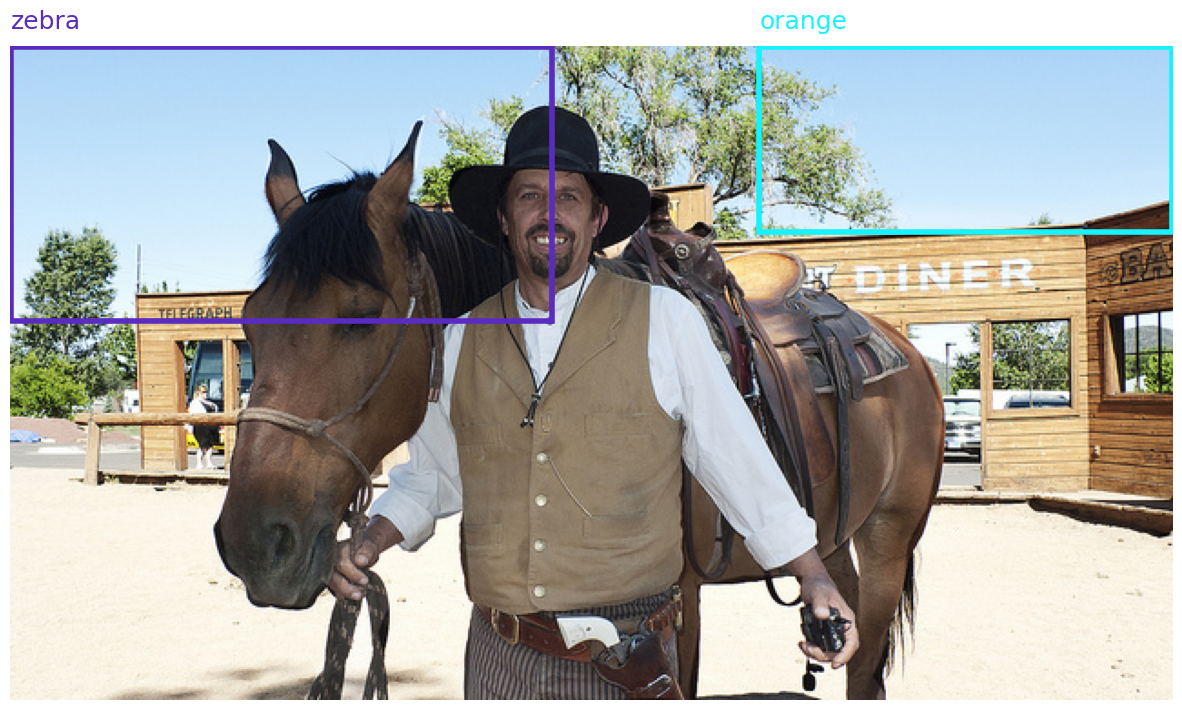

In [7]:
fig, ax = plt.subplots(figsize=(15,15))

#print(image_path)
image, masks = infer_model(image=image_path,choice = choice)
ax.imshow(image)
plt.axis("off")
stability_score_threshold = (np.sum([masks[mask_idx]['stability_score'] for mask_idx in range(len(masks))])/len(masks))
#stddev = np.std([masks[mask_idx]['stability_score'] for mask_idx in range(len(masks))])
objects_detected = 0
for mask_idx in range(len(masks)):
    x, y , w, h = masks[mask_idx]['bbox']
    rand_color = [np.random.rand(), np.random.rand(), np.random.rand()]
    rect = patches.Rectangle((x,y), w, h, linewidth=4, edgecolor=rand_color, facecolor='none')
    #cropped_image = (image * np.expand_dims(masks[mask_idx]['segmentation'],axis=-1) )[y:y+h, x:x+w] #cropped image background is removed and replaced with black
    cropped_image = image[y:y+h, x:x+w] #cropped image background is not removed
    
    predictions = infer_modelCLIP( image = np.array(cropped_image),choice = choice)

    predicted_objects = predictions["label"].tobytes().decode('utf-32').split(',')
    #print(predicted_objects)
    #in_coco = False
    for each in predicted_objects:
        if each in categories:
            #in_coco = True
            objects_detected += 1
            ax.add_patch(rect) #Show red bounding box
            
            # Add text above the bounding box
            text_y = y - 10  # Adjust the y-coordinate for positioning the text
            ax.text(x, text_y, each, fontsize=18, color=rand_color)
print("SAM and OpenCLIP Object Predictions")
if (objects_detected > 0):
    print("There are %d objects detected" % (objects_detected))
else:
    print("No objects detected.")
#plt.figure()
plt.savefig('plot2.png')
plt.show()


YOLO objects prediction


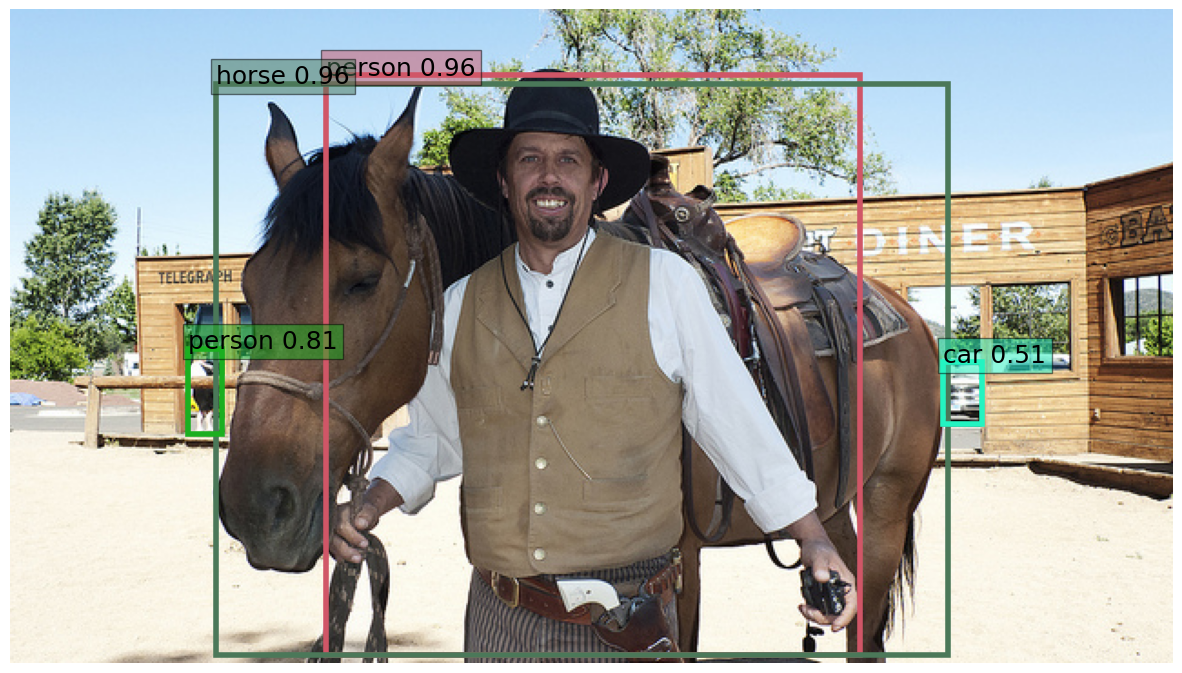

In [8]:
print("YOLO objects prediction")
names, bboxes,probs = infer_modelYOLO(image = image,choice=choice)
# Plotting
fig, ax = plt.subplots(1, figsize=(15, 15))
ax.imshow(image)
ax.axis('off')
for i in range(len(names)):
    if probs[i] > 0.5:
        x1, y1, x2, y2 = bboxes[i]
        w = x2 - x1
        h = y2 - y1
        # make the color random
        color = np.random.rand(3,)
        rect = plt.Rectangle((x1, y1), w, h, linewidth=4, fill=False, color=color)
        ax.add_patch(rect)
        # use the color and add transparency of 0.5
        color = np.append(color, 0.5)
        # add text with white background
        ax.text(x1, y1, f"{names[i]} {probs[i]:.2f}", color='black', fontsize=18, bbox=dict(facecolor=color, alpha=0.5))
plt.savefig('plot3.png')
plt.show()

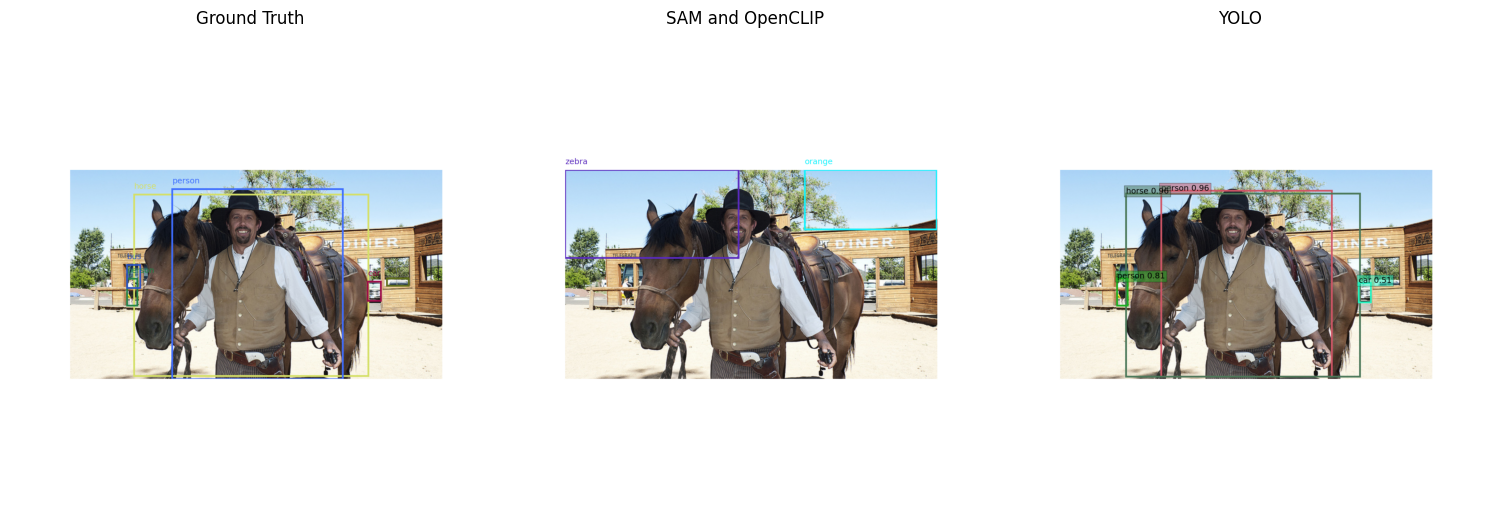

In [9]:
# Read the plot images
plot1 = plt.imread('plot1.png')
plot2 = plt.imread('plot2.png')
plot3 = plt.imread('plot3.png')

# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 10))  # Adjust figsize as needed

# Display the plots in the subplots
axes[0].imshow(plot1)
axes[0].axis('off')
if choice != 2:
    axes[0].set_title('Uploaded Image')
else:
    axes[0].set_title('Ground Truth')

axes[1].imshow(plot2)
axes[1].axis('off')
axes[1].set_title('SAM and OpenCLIP')

axes[2].imshow(plot3)
axes[2].axis('off')
axes[2].set_title('YOLO')

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()


In [ ]:
Evaluating Model using mAP

In [ ]:
#Run images through SAM and OpenCLIP and save results to list
cores = multiprocessing.cpu_count() #Enter number of cores to use in parallel don't change line to use all cores

imageId_list = coco.getImgIds()
results = []

test_length = 100 #Select only first N images of val dataset

#Process object detection in parallel
with multiprocessing.Pool(cores) as pool:
    args = [(imageId_list[i],coco) for i in range(test_length)]
    results = pool.starmap(detect_object, tqdm_notebook(args, total=test_length))
    
flattened_results = [element for sublist in results for element in sublist] #flatten results to one list


  0%|          | 0/100 [00:00<?, ?it/s]

397133,87038,6818,331352,502136,348881,181666,303818,322864,308394,41888,297343,336587,184321,296649,491497,480985,456496,289393,17627,174482,565778,463730,58636,37777,522713,122745,226111,219578,500663,403817,239274,143931,458054,184791,555705,403385,314294,85329,418281,252219,286994,329323,386912,443303,153299,460347,301867,356427,25560,516316,233771,360661,266409,577539,125211,511321,448365,312421,16228,430961,180135,109798,562121,572517,369370,35197,515445,486438,80671,475779,382088,180560,270244,173383,321214,370677,355257,185250,400573,349860,199551,502737,474028,347693,473237,78915,104612,515579,142092,228144,239347,438862,66523,39956,238866,206027,514508,476258,63154,

In [10]:
#Save predictions to json file
output_file = "./coco_data.json"
with open(output_file, "w") as f:
    json.dump(flattened_results, f)

print("COCO data saved to", output_file)



NameError: name 'flattened_results' is not defined

In [11]:
#Open 
annType = ['segm','bbox','keypoints']
annType = annType[1]      #specify type here
print('Running demo for *%s* results.'%(annType))
cocoDt=coco.loadRes('./coco_data.json')
imgIDs=coco.getImgIds()
imgIDs=imgIDs[0:test_length]
imgID = imgIDs[np.random.randint(test_length)]

Running demo for *bbox* results.
Loading and preparing results...


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
cocoEval = COCOeval(coco,cocoDt,annType)
cocoEval.params.imgIds  = imgIDs
cocoEval.evaluate()
cocoEval.accumulate()
cocoEval.summarize()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.023
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.019
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.033
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.023
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.015
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.020
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100